In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./')

In [2]:
# General imports
import json
import os
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum

In [3]:
@dataclass
class SchedulerType(Enum):
    """The type of scheduler to use."""

    BASELINE = auto()
    SIMPLE = auto()
    EXTENDED = auto()  

In [4]:

# Find the type of algorithm
typeAlgorithm = os.listdir('component/d_scheduling/algorithm')
cleantypeAlgorithm = [item for item in typeAlgorithm if item not in ['__pycache__', '__init__.py']]
# make clean typeAlgorithm
dictAlgorithm = {}
for item in cleantypeAlgorithm:
    dictAlgorithm[item] = os.listdir('component/d_scheduling/algorithm/' + item)
    # make clean nameAlgorithm
    cleandictAlgorithm = [item for item in dictAlgorithm[item] if item not in ['__pycache__', '__init__.py']]
    dictAlgorithm[item] = cleandictAlgorithm

print(dictAlgorithm)


{'ilp': ['MILQ_extend', 'MILQ_simple'], 'ai': [], 'heuristic': []}


In [5]:
# Get list backend
from component.a_backend import backend_info
backend_list = [member.name for member in backend_info.IBMQBackend]
print(backend_list)

['BELEM', 'NAIROBI', 'QUITO']


In [ ]:
# Draw struct of backend
# using fakebackend or using aer simulator


- **ae**: Amplitude Estimation (AE)
- **dj**: Deutsch-Jozsa
- **grover-noancilla**: Grover’s (no ancilla)
- **grover-v-chain**: Grover’s (v-chain)
- **ghz**: GHZ State
- **graphstate**: Graph State
- **portfolioqaoa**: Portfolio Optimization with QAOA
- **portfoliovqe**: Portfolio Optimization with VQE
- **qaoa**: Quantum Approximation Optimization Algorithm (QAOA)
- **qft**: Quantum Fourier Transformation (QFT)
- **qftentangled**: QFT Entangled
- **qnn**: Quantum Neural Network (QNN)
- **qpeexact**: Quantum Phase Estimation (QPE) exact
- **qpeinexact**: Quantum Phase Estimation (QPE) inexact
- **qwalk-noancilla**: Quantum Walk (no ancilla)
- **qwalk-v-chain**: Quantum Walk (v-chain)
- **random**: Random Quantum Circuit
- **realamprandom**: Real Amplitudes ansatz with Random Parameters
- **su2random**: Efficient SU2 ansatz with Random Parameters
- **twolocalrandom**: Two Local ansatz with Random Parameters
- **vqe**: Variational Quantum Eigensolver (VQE)
- **wstate**: W-State
- **shor**: Shor’s
- **pricingcall**: Pricing Call Option
- **pricingput**: Pricing Put Option
- **groundstate**: Ground State
- **routing**: Routing
- **tsp**: Travelling Salesman

In [ ]:
# create benchmark

from mqt.bench import get_benchmark, QiskitSettings

qc_algorithmic_level = get_benchmark(benchmark_name="routing", level="alg", circuit_size=3)
qc_algorithmic_level.draw("text")

/home/trieu/anaconda3/envs/squan/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


»
   q_0: »
        »
   q_1: »
        »
   q_2: »
        »
   q_3: »
        »
   q_4: »
        »
   q_5: »
        »
meas: 6/»
        »
«        ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«   q_0: ┤0                                                                                                                                                                                                           ├»
«        │                                                                                                                                                                                                            │»
«   q_1: ┤1                                                                                                                                                                                                           ├»
«        │                                                                                                                                                                                                            │»
«   q_2: ┤2                                                                                                                                                                                                           ├»
«        │  RealAmplitudes(-0.031516,-2.3821,-0.070328,1.4424,2.1779,2.3221,-0.02536,0.85082,2.8984,-1.5047,-1.4992,1.0589,-2.7838,0.94967,1.681,-0.44245,1.432,2.3438,-0.41972,1.4816,-0.89864,-1.5511,-1.482,1.578) │»
«   q_3: ┤3                                                                                                                                                                                                           ├»
«        │                                                                                                                                                                                                            │»
«   q_4: ┤4                                                                                                                                                                                                           ├»
«        │                                                                                                                                                                                                            │»
«   q_5: ┤5                                                                                                                                                                                                           ├»
«        └────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«meas: 6/══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                                                                                                                      »
«         ░ ┌─┐               
«   q_0: ─░─┤M├───────────────
«         ░ └╥┘┌─┐            
«   q_1: ─░──╫─┤M├────────────
«         ░  ║ └╥┘┌─┐         
«   q_2: ─░──╫──╫─┤M├─────────
«         ░  ║  ║ └╥┘┌─┐      
«   q_3: ─░──╫──╫──╫─┤M├──────
«         ░  ║  ║  ║ └╥┘┌─┐   
«   q_4: ─░──╫──╫──╫──╫─┤M├───
«         ░  ║  ║  ║  ║ └╥┘┌─┐
«   q_5: ─░──╫──╫──╫──╫──╫─┤M├
«         ░  ║  ║  ║  ║  ║ └╥┘
«meas: 6/════╩══╩══╩══╩══╩══╩═
«            0  1  2  3  4  5

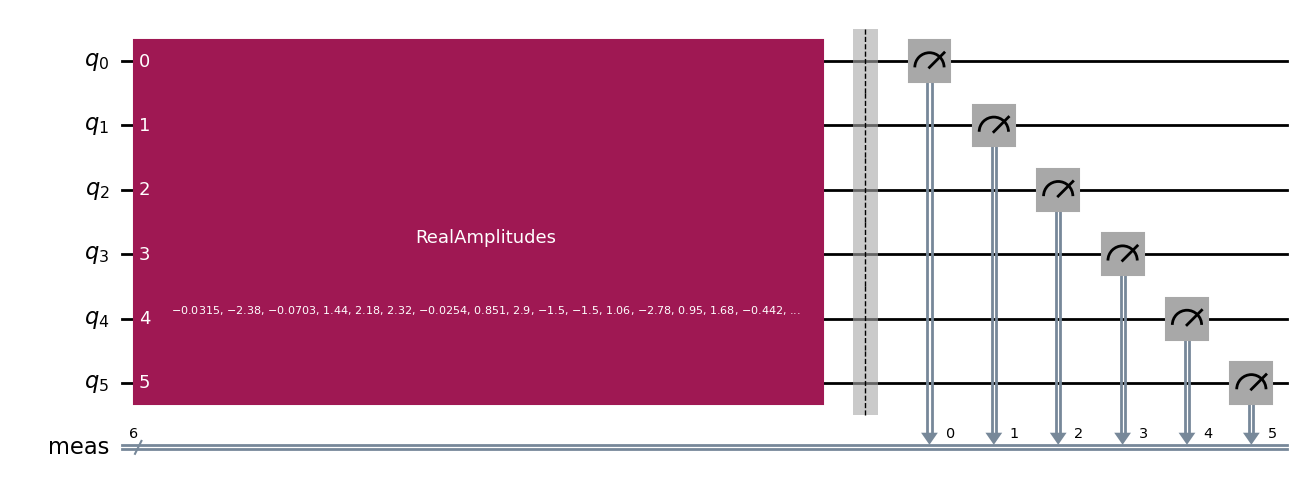

In [13]:
qc_algorithmic_level.draw("mpl")

In [ ]:
# Using circuit cuttng here
# using qiskit circuit-cutting gate, wire here

In [ ]:
#translate to data for input to scheduling, for each algorithm, we have dif define here

In [6]:
# Configuration
# 1. Number of Jobs in the batch
jobs = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}
# 2. Number of machines
machines = {"QUITO": 5, "BELEM": 5}
# 3. Scheduling type

In [7]:
# Setup
bigM = 1000000
timesteps = 2**5

from component.d_scheduling.algorithm.ilp.MILQ_extend import MILQ_extend_implementation

In [8]:
# Scheduler
MILQ_extend_implementation.example_problem(bigM, timesteps, "component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/trieu/anaconda3/envs/squan/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/eba9885daf884917acb1026d3ff20799-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/eba9885daf884917acb1026d3ff20799-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 710 COLUMNS
At line 4649 RHS
At line 5355 BOUNDS
At line 5860 ENDATA
Problem MODEL has 705 rows, 514 columns and 2929 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.24521 - 0.00 seconds
Cgl0002I 8 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 493 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 394 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 202 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 176 strengthened rows, 

In [ ]:
#mapping the scheduling result to the machine
# check qiskit_102

In [ ]:
# assemble the circuit with calculation time in scheduling
# don't know

In [ ]:
# reconstruct circuit after cutting
# don't know

In [ ]:
# get the value

  job  qubits machine  capacity  start   end  duration
0   A       2   QUITO         5    0.0  14.0      14.0
1   B       3   QUITO         5    0.0   8.0       8.0
2   C       5   BELEM         5    0.0  20.0      20.0
3   D       2   QUITO         5    9.0  21.0      12.0


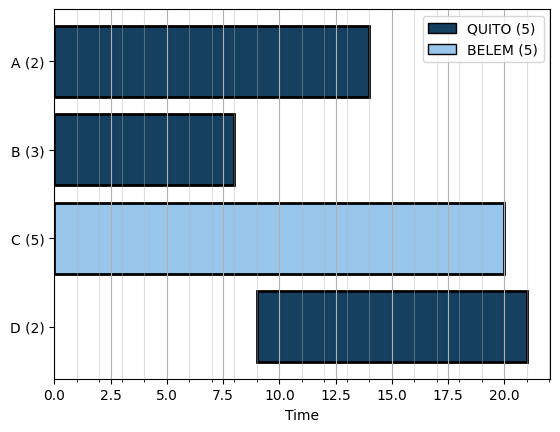

In [9]:
# Visualize
from component.d_scheduling.visualize import ilp

ilp.visualize("component/d_scheduling/algorithm/ilp/MILQ_extend/MILQ_extend_result.json")


In [ ]:

# Analyze